## Summary of Notebook

This notebook contains the implementation of the EfficientNetB0 model with unforzen architecture. It provides the results obtained from this model and its performance across the training, validation, and testing phases.

## Set Up
Here, we will begin by downloading the necessary dataset for flowers102, followed by the creation of dataloaders and the implementation of train and test functions.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
from scipy.io import loadmat
import pandas as pd
from torch.utils.data import Dataset
import json

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [ ]:
train_dataset = torchvision.datasets.Flowers102("./data/train", split="train", download=True, transform=data_transforms["train"])
val_dataset = torchvision.datasets.Flowers102("./data/val", split="val", download=True, transform=data_transforms["val"])
test_dataset = torchvision.datasets.Flowers102("./data/test", split="test", download=True, transform=data_transforms["test"])

100%|██████████| 344862509/344862509 [00:13<00:00, 24893589.54it/s]


Extracting data/train/flowers-102/102flowers.tgz to data/train/flowers-102


100%|██████████| 502/502 [00:00<00:00, 581480.42it/s]


100%|██████████| 14989/14989 [00:00<00:00, 25514781.92it/s]


100%|██████████| 344862509/344862509 [00:18<00:00, 18837211.07it/s]


Extracting data/val/flowers-102/102flowers.tgz to data/val/flowers-102


100%|██████████| 502/502 [00:00<00:00, 448368.95it/s]


100%|██████████| 14989/14989 [00:00<00:00, 11784146.70it/s]


100%|██████████| 344862509/344862509 [00:14<00:00, 23775688.84it/s]


Extracting data/test/flowers-102/102flowers.tgz to data/test/flowers-102


100%|██████████| 502/502 [00:00<00:00, 400521.33it/s]


100%|██████████| 14989/14989 [00:00<00:00, 24386509.95it/s]


In [ ]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True)

In [ ]:
dataloaders = {}
dataloaders["train"] = train_dataloader
dataloaders["val"] = val_dataloader
dataloaders["test"] = test_dataloader

In [ ]:
dataset_sizes = {}
dataset_sizes["train"] = len(train_dataloader.dataset)
dataset_sizes["val"] = len(val_dataloader.dataset)
dataset_sizes["test"] = len(test_dataloader.dataset)

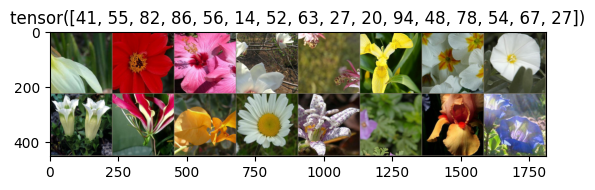

In [ ]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated



# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=classes)



In [ ]:
def test_model(model, criterion):
  running_loss = 0.0
  running_corrects = 0
  for inputs, labels in dataloaders["test"]:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)
    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)
  total_loss = running_loss / dataset_sizes["test"]
  total_acc = running_corrects.double() / dataset_sizes["test"]
  return total_loss, total_acc

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    train_accuracies = []
    val_accuracies = []
    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                if phase == "train":
                  train_accuracies.append(epoch_acc)
                else:
                  val_accuracies.append(epoch_acc)

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model, train_accuracies, val_accuracies

In [ ]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

model_conv = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
model_conv = efficientnet_b0(weights="DEFAULT")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 70.5MB/s]


### Modify Last Layer and Train the Entire Model with the Pre-trained Weights

In this section, we will train the EfficientB0 model on the flowers102 dataset. Our only modification will be adjusting the last layer to have 102 neurons. The remaining architecture of EfficientB0 will remain unchanged, with all other layers unfrozen.

In [ ]:
model_ft = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
model_ft = efficientnet_b0(weights="DEFAULT")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
num_ftrs = model_ft.classifier[1].in_features


model_ft.classifier = nn.Sequential(
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(num_ftrs, 102),
        )


criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft, train_accuracies_ft, val_accuracies_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 5.5752 Acc: 0.0961
val Loss: 2.9271 Acc: 0.3971

Epoch 1/24
----------
train Loss: 2.4202 Acc: 0.4804
val Loss: 1.4161 Acc: 0.6588

Epoch 2/24
----------
train Loss: 1.3983 Acc: 0.6618
val Loss: 0.9010 Acc: 0.7657

Epoch 3/24
----------
train Loss: 0.9648 Acc: 0.7588
val Loss: 0.7477 Acc: 0.8157

Epoch 4/24
----------
train Loss: 0.7215 Acc: 0.8225
val Loss: 0.6156 Acc: 0.8196

Epoch 5/24
----------
train Loss: 0.5568 Acc: 0.8539
val Loss: 0.5537 Acc: 0.8657

Epoch 6/24
----------
train Loss: 0.4884 Acc: 0.8745
val Loss: 0.5272 Acc: 0.8735

Epoch 7/24
----------
train Loss: 0.4008 Acc: 0.9049
val Loss: 0.4459 Acc: 0.8902

Epoch 8/24
----------
train Loss: 0.3172 Acc: 0.9245
val Loss: 0.4351 Acc: 0.8922

Epoch 9/24
----------
train Loss: 0.3409 Acc: 0.9118
val Loss: 0.4047 Acc: 0.9010

Epoch 10/24
----------
train Loss: 0.3100 Acc: 0.9275
val Loss: 0.3944 Acc: 0.9000

Epoch 11/24
----------
train Loss: 0.2879 Acc: 0.9324
val Loss: 0.4061 Acc: 0.9069

Ep

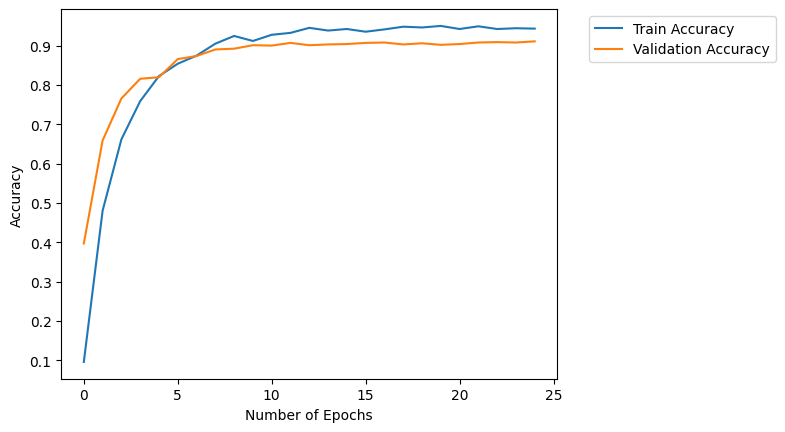

In [ ]:
plt.plot(range(25), train_accuracies_ft, label="Train Accuracy")
plt.plot(range(25), val_accuracies_ft, label="Validation Accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.yticks(np.arange(0.1, 1, 0.1))
plt.show()

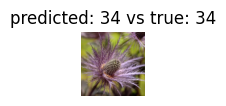

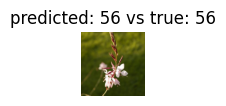

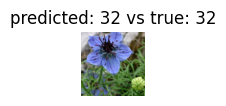

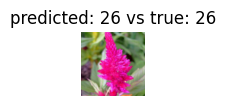

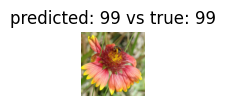

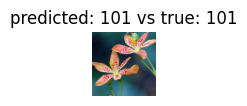

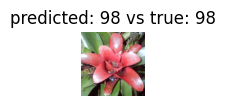

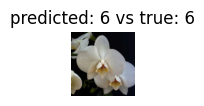

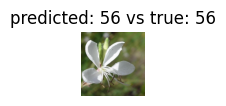

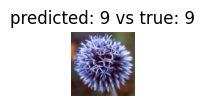

In [ ]:
visualize_model(model_ft, num_images=10)

In [ ]:
torch.save(model_ft, "/content/drive/MyDrive/SC4001/Team Project/EfficientNetB0/PreTrain.pth")

In [ ]:
model_ft = torch.load("/content/drive/MyDrive/SC4001/Team Project/EfficientNetB0/PreTrain.pth")

In [ ]:
# test accuracies for the 3 models
criterion = nn.CrossEntropyLoss()
loss_ft, accuracy_ft = test_model(model_ft, criterion)

In [1]:
print(f"{ 'Test Loss (No Freeze)'.ljust(30) } : {loss_ft:.4f}")
print(f"{ 'Test Accuracy (No Freeze)'.ljust(30) } : {accuracy_ft:.4f}")

Test Loss (No Freeze)          : 0.4610
Test Accuracy (No Freeze)      : 0.8787
